In [1]:
from Common_functions import *

In [2]:
from Planetary_fits import *

In [3]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
from tqdm import tqdm
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
from scipy.interpolate import interp1d
import pandas as pd
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition) 
import traceback
from lmfit import minimize, Parameters, Parameter, report_fit
import math
from sympy.solvers import solve
from sympy import Symbol
import sympy


%matplotlib inline
home = os.path.expanduser("~")

In [4]:
def PSPL_data (params, t, A_data):
    
    t0 = params['t0'].value
    tE = params['tE'].value
    u0 = params['u0'].value
    fs = params['fs'].value
#     fb = params['fb'].value

    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    F = (fs * (A-1)) +1
    return A - A_data

def PSPL (t0, tE, u0,fs, t):
    
    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    F = (fs * (A-1)) +1
    return F


def PSPL_Gaussian (t0,tE, u0,fs,tp, tEp,amp, t):
#     u = np.sqrt(u0**2+((t-t0)/tE)**2)
    F = PSPL (t0, tE, u0,fs, t) + Gaussian (tp, tEp,amp, t)
    #= (((amp/np.sqrt(2*pi*(sigma**2)))*np.exp(-((t-mean)**2)/(2*(sigma**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    #F = (fs * (A-1)) +1
    return F

def PSPL_Gaussian_data (params, t, A_data):
    
    t0 = params['t0'].value
    tE = params['tE'].value
    u0 = params['u0'].value
    tp = params['tp'].value
    tEp = params['tEp'].value
    amp = params['amp'].value
    fs = params['fs'].value
#     fb = params['fb'].value
    
    u = np.sqrt(u0**2+((t-t0)/tE)**2)
    #A = (((amp/np.sqrt(2*pi*(tEp**2)))*np.exp(-((t-tp)**2)/(2*(tEp**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    #F = (fs * (A-1)) +1
    F = PSPL (t0, tE, u0,fs, t) + Gaussian (tp, tEp,amp, t)

    return F - A_data


def Gaussian (tp, tEp,amp, t):
    A = amp*np.exp(-1*((t-tp)**2)/(2*(tEp**2)))
    #(((amp/np.sqrt(2*pi*(sigma**2)))
#     F = (fs * (A-1)) +1
    return A

def Gaussian_data (params, t, A_data):
    

    tp = params['tp'].value
    tEp = params['tEp'].value
    amp = params['amp'].value
#     fs = params['fs'].value
#     fb = params['fb'].value
    
    A = amp*np.exp(-1*((t-tp)**2)/(2*(tEp**2)))
    #(((amp/np.sqrt(2*pi*(sigma**2)))

    return A- A_data

In [5]:
# def deviation_finder (t, A_residual, PSPL_params,  binsize_initial = 600, threshold_default = 3):
    
#     std_base = np.std(A_residual[(t > PSPL_params[0]+10*PSPL_params[1]) | (t < PSPL_params[0]-10*PSPL_params[1]) ])
#     std_all = np.std(A_residual)
#     percent_diff = (np.abs(std_base-std_all)/float(std_all))*100
    
#     if percent_diff < 50:
#         smoothie ='yes'
# #         print 'Smooth'
#     else:
#         smoothie ='no'
# #         print 'Do not smooth'
        
#     b_s = binsize_initial
    
#     n_out, peaks = count_peaks (t, A_residual, smooth=smoothie, bin_size =b_s, threshold = threshold_default)

#     n_peaks = len(peaks)
#     temp_peaks = peaks
# #     print n_peaks
    
#     c = 0
    
#     if (c != 2) & (percent_diff > 5):
    
#         while c != 2 :
#             if b_s < 0.2:
# #                 print 'No two peaks were found!'
#                 break

#             b_s = b_s/2.
# #             print b_s
#             n_out2, temp_peaks = count_peaks (t, A_residual, smooth=smoothie, bin_size =b_s, threshold = 3)
#             c = len(temp_peaks)

#     if len(temp_peaks) == 2 :
#         if np.abs(temp_peaks[0]-temp_peaks[1])<100:
#             peaks = temp_peaks
#             n_peaks = len(temp_peaks)

    
# #     if (np.abs(temp_peaks[1]-temp_peaks[0]) <0.1) or (np.abs(temp_peaks[1]-temp_peaks[0]) > 10):
# #             b_s_ = [4,3,2, 1, 0.5]
# #             # print '<0.1 or >10'
# #             for b in b_s_:
                
# #                 n_out, temp_peaks = count_peaks (t, A_residual, smooth='yes', bin_size =b, threshold = 3)

# #                 if (len(temp_peaks) == 2):
# #                     if (np.abs(temp_peaks[1]-temp_peaks[0]) >0.1) and (np.abs(temp_peaks[1]-temp_peaks[0]) < 10):
# #                         # print '>0.1 and <10'
# #                         peaks = temp_peaks
# #                         n_peaks = len(temp_peaks)
                        
#     if (np.abs(temp_peaks[1]-temp_peaks[0]) <0.2):
        
#         peaks = [temp_peaks[0]]
#         n_peaks = 1
# #     print n_peaks
    
    
#     return n_peaks, peaks

In [6]:
def tE_finder (t, A, t0, u0, dt):
    print t0, u0, dt
    duration = [0.01, 1, 10,100,1000]
    temp = [[], []]

    for tEp in duration:
    #     for a in range(0,2):

    #     print tEp, f_ris__[a]
        params2 = Parameters()
        params2.add('tp', value= t0, min=t0-1, max=t0+1)
        params2.add('tEp', value= tEp, min=tEp/1.1, max=tEp*1.1)
        params2.add('amp', value= max(A),  min=max(A)/1.1, max=max(A)*1.1)
        # params.add('fs', value= 1, min=0, max=1)
        # params.add('fb', value= 0, min=0, max=1)
        result2 = minimize(Gaussian_data, params2, args=(t, A))
        temp[0].append(result2.params)
        temp[1].append(result2.chisqr)
        print tEp
        print result2.params
        print result2.chisqr

    tE = temp[0][np.argmin(temp[1])]['tEp'].value
#     if tE > 3798:
#         tE = dt
    

    return tE

In [7]:
# Set up te directory where all microlensing data challenge lightcurves are

temp_dir = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'
direc = os.listdir(temp_dir)

In [22]:
# Reading in one single lightcurve from the small sample of data challenge light curves

f = '/mag.omcassan_0_32_977.det.lc.W149' #non-binary

t,m,e = np.loadtxt(temp_dir+f,unpack=True)

lightcurve = np.zeros((len(t),4))
lightcurve[:,0] = t
lightcurve[:,1] = m
lightcurve[:,2] = e
peak = t[np.argmin(m)]

t = t-2458234

# (baseline, event, it0) = localize_event(lightcurve, peak,50)

df, baseline, event, it0, dt = prepare(t,m,e)
print dt

A_max = df['A'][np.argmin(m[m>np.percentile(m, [0.0,99.4])[0]])] #np.max(df['A']) #1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true =  df['t'][np.argmin(m[m>np.percentile(m, [0.0,99.4])[0]])] 
print t0_true
if u0_true <0.5 :
    A_lim = 1.34
else:
    A_lim = 1.06
interpol = interp1d(df['t'],df['A'], kind='cubic')
dt = np.abs(df['t'][np.argmin(np.abs(interpol(df['t'])-A_lim))]-t0_true)
tE_true = dt

print u0_true, tE_true
t

5.979964000172913
1804.332622999791
0.1608201067705366 1.56341200042516


array([ 112.505461,  112.515987,  112.526513, ..., 1825.220391,
       1825.230917, 1825.241444])

In [9]:
# name = 'cassan_0_19_2049.det.lc.gz'  
# tempdata = '/Users/Research/Desktop/alllc1/'+str(name)
# #'data/WFIRST_simulated/Multi_caustic_crossing/'+str(name)

# t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
# df = pd.DataFrame({'t':t , 'A':f , 'A_err' : f_err , 'A_true': f_true, 'code':code})
# df = df[df['code']==0]

# A_max = df['A'][ np.argmax( df['A'][df['A'] < np.percentile( df['A'], [0.0,100] )[1]])] 
# u0_true = np.sqrt( ( ( 1 + np.sqrt( 1 + 16 *( A_max ** 2 )))/( 2 * A_max ) ) - 2 )
# t0_true =  df['t'][np.argmax( df['A'][df['A'] < np.percentile( df['A'], [0.0,100] )[1]])] 
# print t0_true
# if u0_true <0.5 :
#     A_lim = 1.34
# else:
#     A_lim = 1.06
# interpol = interp1d(df['t'],df['A'], kind='cubic')
# dt = np.abs(df['t'][np.argmin(np.abs(interpol(df['t'])-A_lim))]-t0_true)
# tE_true = dt

# print u0_true, tE_true

In [10]:
# name = 'cassan_30_6_1468.det.lc.gz'  
# tempdata = '/Users/Research/Desktop/alllc1/'+str(name)
# #'data/WFIRST_simulated/Multi_caustic_crossing/'+str(name)

# t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
# df = pd.DataFrame({'t':t , 'A':f , 'A_err' : f_err , 'A_true': f_true, 'code':code})
# df = df[df['code']==0]


# A_max = df['A'][np.argmax(df['A'][df['A']<np.percentile(df['A'], [0.0,100])[1]])] #np.max(df['A']) #1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
# u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
# t0_true =  df['t'][np.argmax(df['A'][df['A']<np.percentile(df['A'], [0.0,100])[1]])] #it0 #t[A.argmax()] #float(t0_theo)
# print t0_true
# if u0_true <0.5 :
#     A_lim = 1.34
# else:
#     A_lim = 1.06
# interpol = interp1d(df['t'],df['A'], kind='cubic')
# dt = np.abs(df['t'][np.argmin(np.abs(interpol(df['t'])-A_lim))]-t0_true)
# tE_true = dt
# print u0_true


In [23]:
print sum(df['t']), sum(df['A']), sum(df['A_err']), [t0_true,tE_true, u0_true]
tE_ = [[],[]]
nll = lambda *args: -lnlike(*args)
res_scipy = op.minimize(nll, [t0_true,tE_true, u0_true, 0.5], args=(df['t'],df['A'], df['A_err']),method = 'Nelder-Mead')
t0_ml, tE_ml, u0_ml,fs_ml = res_scipy['x']
tE_[0].append(lnlike([t0_ml, tE_ml, u0_ml,fs_ml],df['t'],df['A'], df['A_err']))
tE_[1].append([t0_ml, tE_ml, u0_ml,fs_ml])
        
#print tE_[1]
mm = np.asarray(tE_[0]) #tE_[0])
params = tE_[1][0] #[mm.argmax()]

37367475.709327996 39117.773618877996 442.3174871748663 [1804.332622999791, 1.56341200042516, 0.1608201067705366]


In [24]:
params[0]#-2458234

1804.3694409130649

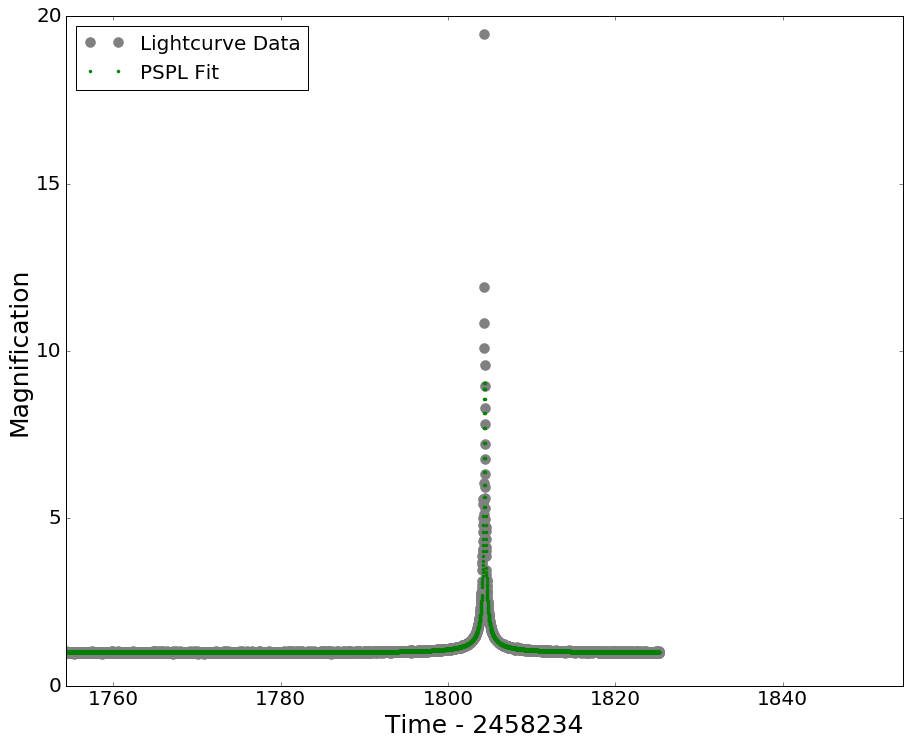

In [25]:
dtt = 50

plt.plot(df['t'],df['A'],'.',color='gray', markersize=20, label='Lightcurve Data')
# plt.plot(df['t']-2458234,PSPL(result1[0].value,result1[1].value,result1[2].value,
#                       result1[3].value, df['t']),'r.', Label='Chebyshev Approximation')
plt.plot(df['t'],PSPL(params[0],params[1],params[2],params[3], df['t']),'g.', Label='PSPL Fit')
# plt.plot(df['t']-2458234, Gaussian(2459559.085540818, 1338.1274574555948, 1.307063624033818, df['t']), 'r.')
plt.ylabel('Magnification', size=25)
plt.xlabel('Time - 2458234', size=25)
#plt.title('Chebyshev approximation of a Binary-lens Microlensing Lightcurve',size=25)
plt.xlim(t0_true-dtt, t0_true+dtt)
plt.legend(loc=2,fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# print result.params

fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# plt.savefig('Chebyshevfit_success.png')

In [26]:
df['A_residual'] = df['A'] - PSPL(params[0],params[1],params[2],params[3], df['t'])

(1754.3694409130649, 1854.3694409130649)

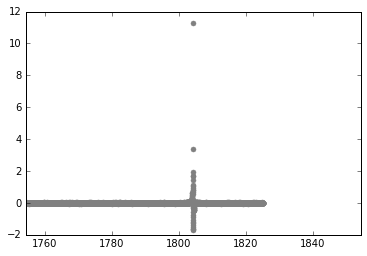

In [27]:
dtt = 50

plt.plot(df['t'], df['A_residual'] ,'.',color='gray', markersize=10)

plt.xlim(params[0]-dtt, params[0]+dtt)



In [28]:
b_s = 700
n_out, peaks = count_peaks (df['t'], df['A_residual'], smooth='yes', bin_size =b_s, threshold = 3)

n_peaks = len(peaks)
print n_peaks

1


In [29]:
if n_peaks != 2:
    
    while n_peaks != 2 :
        if b_s<0.5:
            print 'No two peaks were found!'
            break
        
        b_s = b_s/2.
        print b_s
        n_out, peaks = count_peaks (df['t'], df['A_residual'], smooth='yes', bin_size =b_s, threshold = 3)

        n_peaks = len(peaks)
print n_peaks

350.0
175.0
87.5
43.75
21.875
10.9375
5.46875
2.734375
1.3671875
0.68359375
2


In [31]:
n_peaks, peaks = deviation_finder (df['t'], df['A_residual'] , params)

In [19]:
# if np.abs(peaks[1]-peaks[0]) >10:
#     n_out, peaks = count_peaks (df['t'], df['A_residual'], smooth='yes', bin_size =2, threshold = 3)

In [32]:
np.abs(peaks[0]-peaks[1])

0.24210699973627925

(-2456430.909484, -2456428.909484)

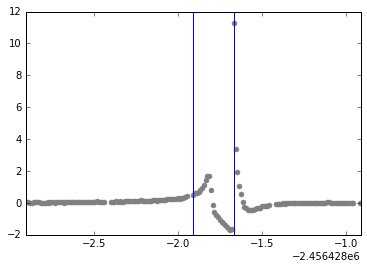

In [33]:
dtt = 1



plt.plot(df['t']-2458234, df['A_residual'] ,'.',color='gray', markersize=10)
for peak in peaks:
    plt.axvline(peak-2458234)
plt.xlim(peaks[0]-2458234-dtt, peaks[0]-2458234+dtt)



In [211]:
print params[0]-peak

-3.447512544575204


In [264]:
std_base = np.std(df['A_residual'][(df.t > params[0]+10*params[1]) | (df.t < params[0]-10*params[1]) ])

In [265]:
std_all = np.std(df['A_residual'])

In [266]:
(np.abs(std_base-std_all)/float(std_all))*100

10.65020381740833

In [64]:
params[2]

0.03475395225342216

In [267]:
calculate_s_q_double(params[0], params[1], params[2], peaks)

(4.59409504579627, 6.258929386460773e-05)

In [269]:
t0, tE, u0 = params[0], params[1], params[2]
print peaks

u1 = np.sqrt( ((peaks[0]-t0)/tE)**2 + (u0)**2 )
u2 = np.sqrt( ((peaks[1]-t0)/tE)**2 + (u0)**2 )

s0s1 = np.sqrt( (u1)**2 - (u0)**2 )
s0s2 = np.sqrt( (u2)**2 - (u0)**2 )
s1s2 = s0s1 - s0s2
xs1 = (s1s2 * s0s1) / u1
print xs1
Lx = u1 - xs1


s0 = Symbol('s0')
s_final = (solve(s0-(1/s0)-Lx, s0))[1]

print s_final

if (xs1<0) or (xs1 > (2./(float(s_final)*np.sqrt(float(s_final)**2 -1)))):


    q_final	 = ((peaks[1]-peaks[0])/tE)**2

else:


    q_final = ( xs1*float(s_final)*np.sqrt(float(s_final**2 -1))/2. )**2
print q_final

[1456.1978110000491, 1456.2504429998808]
-0.00036423181088144133
4.59409504579627
6.258929386460773e-05
